# NYC taxis tips 

In [1]:
# Import des librairies
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot  as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [2]:
# Setup de pandas pour la visualisation de dataframes
pd.set_option('display.max_columns', None)

In [3]:
#Import des datasets
train = pd.read_parquet("C:\Datasets\\taxis\\train.parquet")
test = pd.read_parquet("C:\Datasets\\taxis\\test.parquet")

In [4]:
#On garde en copie les datasets originelles en memoire au cas ou on a besoin plus tard
train_original = train.copy()
test_original = test.copy()

## Exploration des donnees

### Presentation de features

In [5]:
#Du blabla?
train.head()
test.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
row_ID,,,,,,,,,,,,,,,,,,,
0,2,2024-01-24 08:02:47,2024-01-24 08:04:45,1.0,0.36,1.0,N,1,4.4,0.0,0.5,0.0,1.0,2.5,0.0,40.740439,-73.976495,40.747746,-73.978492
1,2,2024-01-26 14:34:58,2024-01-26 14:42:51,1.0,1.78,1.0,N,1,10.7,0.0,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.790011,-73.945750
2,2,2024-01-24 15:47:27,2024-01-24 15:51:48,2.0,0.43,1.0,N,2,5.8,0.0,0.5,0.0,1.0,0.0,0.0,40.791705,-73.973049,40.797962,-73.968168
3,2,2024-01-04 14:40:17,2024-01-04 14:44:21,1.0,0.61,1.0,N,1,5.8,0.0,0.5,0.0,1.0,2.5,0.0,40.783961,-73.978632,40.791705,-73.973049
4,2,2024-01-16 05:54:03,2024-01-16 05:55:59,1.0,0.71,1.0,N,2,5.1,1.0,0.5,0.0,1.0,2.5,0.0,40.748427,-73.999918,40.748427,-73.999918


### Nettoyage et preparation des données

On commence d'abord par un nettoyage rutinaire des données, visant se débarraserd es valeurs NaN. On remarque qu'il n'y a pas de données manquantes.

In [6]:
# NaNs per colonne
missing_values = train.isnull().sum()

# Colonnes avec des NaN
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

Series([], dtype: int64)


Avant de procéder à une étude univariée et bivariée, nous devons transformer certaines variables en formats numériques. Pour l'instant, nous effectuerons des transformations de base pour procéder à une étude, et dans une section ultérieure, nous effectuerons des transformations plus avancées des variables.

In [7]:
# Nous créons une unique variable à partir des variables avec format datetype
train['trip_duration'] = (train['tpep_dropoff_datetime'] - train['tpep_pickup_datetime']).dt.total_seconds() / 60 # Trip duration in minutes
test['trip_duration'] = (test['tpep_dropoff_datetime'] - test['tpep_pickup_datetime']).dt.total_seconds() / 60 

# Encoding des variables categorielles: d'abord on teste des encodings basiques
# Store_and_fwd_flag: dummy
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

### Étude univariée et bivariée

##### Univariée
Nous examinons ici les distributions de certaines covariables. Nous nous intéressons en particulier à la cohérence des valeurs prises par les covariables ainsi qu'aux valeurs extrêmes.

##### Trip duration
We first look for extreme values. We can safely assume that any trip that is over 5 hours (300 min) long is an error. In the same way, the duration for a trip can't be 0.

   

In [8]:
len(train[train['trip_duration']>300]['trip_duration']) # 63 such trips in the training set
len(test[test['trip_duration']>300]['trip_duration']) #!! 1689 trips in the test set

#This suggests that distributions might not be similar across train and test sets. Let's now check trips of duration 0:

len(train[train['trip_duration']==0]['trip_duration']) #1
len(test[test['trip_duration']==0]['trip_duration']) #33

# We have less cases. Let's investigate if these are cancelled trips or just errors:

33

In [9]:
test[test['trip_duration']==0].head()
#We notice how the trip distance is nonzero, as well as the fare_amount, so these are errors and not cancelled trips. 

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,trip_duration
row_ID,,,,,,,,,,,,,,,,,,,,
125498,1,2024-01-08 15:16:40,2024-01-08 15:16:40,0.0,4.20,1.0,0,2,3.0,0.0,0.5,0.0,1.0,0.0,0.0,40.745379,-73.948892,40.745379,-73.948892,0.0
189900,2,2024-01-09 17:40:00,2024-01-09 17:40:00,1.0,18.60,2.0,0,1,70.0,0.0,0.5,0.0,1.0,2.5,0.0,40.646985,-73.786530,40.723888,-74.001538,0.0
258501,1,2024-01-30 07:32:57,2024-01-30 07:32:57,1.0,0.70,1.0,0,1,5.1,2.5,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.791705,-73.973049,0.0
482498,2,2024-01-23 00:00:00,2024-01-23 00:00:00,5.0,3.64,1.0,0,1,102.4,2.5,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.791705,-73.973049,0.0
504436,1,2024-01-16 01:00:18,2024-01-16 01:00:18,1.0,0.70,1.0,0,2,5.8,3.5,0.5,0.0,1.0,2.5,0.0,40.756688,-73.972356,40.756688,-73.972356,0.0


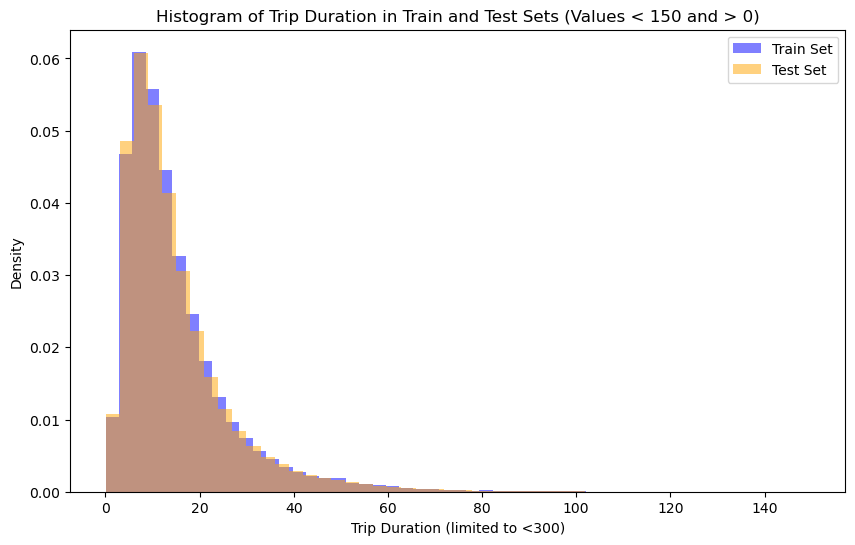

In [10]:
# Filter values to include only those less than 150 (provides clearer visualization than with <300)
train_filtered = train[(train['trip_duration'] > 0) & (train['trip_duration'] < 150)]
test_filtered = test[(test['trip_duration'] > 0) & (test['trip_duration'] < 150)]

# Plot the histograms
plt.figure(figsize=(10, 6))

# Train set histogram
plt.hist(train_filtered['trip_duration'], bins=50, color='blue', alpha=0.5, density=True, label='Train Set')

# Test set histogram
plt.hist(test_filtered['trip_duration'], bins=50, color='orange', alpha=0.5, density=True, label='Test Set')

# Add labels and title
plt.xlabel('Trip Duration (limited to <300)')
plt.ylabel('Density')
plt.title('Histogram of Trip Duration in Train and Test Sets (Values < 150 and > 0)')
plt.legend()
plt.show()


Distributions are very similar. We now need a way of handling the measurement errors. A very natural idea is to use the trip_distance variable. I expect this variable to be highly correlated with trip_duration. Let's verify:

In [11]:
train[['trip_distance', 'trip_duration']].corr().iloc[0, 1] # 0.2614, which is super low
test[['trip_distance', 'trip_duration']].corr().iloc[0, 1] # 0.2656, similar

#Of course, this is the general case with the outliers. Let's see how it should be:

train[(train['trip_duration'] > 0) & (train['trip_duration'] < 300)][['trip_distance', 'trip_duration']].corr().iloc[0, 1] #0.7934
test[(test['trip_duration'] > 0) & (test['trip_duration'] < 300)][['trip_distance', 'trip_duration']].corr().iloc[0, 1] #0.7888



0.7888151400475526

We find much more reasonable values. 

In [12]:
df1 = train[(train['trip_duration'] > 0) & (train['trip_duration'] < 300)].drop(columns=['tip_amount'])
df2 = test[(test['trip_duration'] > 0) & (test['trip_duration'] < 300)]

combined_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

X = combined_df[['trip_distance']]  # Predictor needs to be a 2D array
y = combined_df['trip_duration']    # Response variable

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0]

In [13]:
# We now replace the nonsensical values with a simple estimation of them
# Replace nonsensical values in 'train' DataFrame
train.loc[(train['trip_duration'] == 0) | (train['trip_duration'] > 300), 'trip_duration'] = train.loc[(train['trip_duration'] == 0) | (train['trip_duration'] > 300), 'trip_distance'] * slope


# Replace nonsensical values in 'test' DataFrame
test.loc[(test['trip_duration'] == 0) | (test['trip_duration'] > 300), 'trip_duration'] = test.loc[(test['trip_duration'] == 0) | (test['trip_duration'] > 300), 'trip_distance'] * slope



##### Passenger count

In [14]:
#We replace instances where the passenger count is 0 by instances where it is one

train.loc[train['passenger_count'] == 0, 'passenger_count'] = 1
test.loc[test['passenger_count'] == 0, 'passenger_count'] = 1

In [15]:
test['passenger_count'].value_counts()

passenger_count
1.0    2066425
2.0     376190
3.0      84638
4.0      46990
5.0      31707
6.0      21198
8.0         11
7.0          3
9.0          1
Name: count, dtype: int64

##### Fare amount
We seem to have the same outlier problem we had with the ```trip_duration``` variable. In principle, ```fare_amount``` should be highly correlated with ```trip_distance```, but we notice how the test set presents a considerable number of outliers that seem to be measuring errors. In this section we investigate the matter and do some processing.

In [16]:
train[train['fare_amount']>200] # Only one instance with an appropiate trip_distance. No problems here.
test[test['fare_amount']>200] # although some values seem correct, we notice how how some people got charged devious amounts of money for no apparent reason

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,trip_duration
row_ID,,,,,,,,,,,,,,,,,,,,
19899,2,2024-01-11 11:44:34,2024-01-11 12:16:56,2.0,16.23,5.0,0,2,367.0,0.00,0.0,0.00,1.0,0.0,1.75,40.646985,-73.786530,40.646985,-73.786530,32.366667
20605,2,2024-01-30 23:53:27,2024-01-31 04:34:51,1.0,2.73,1.0,0,1,201.1,1.00,0.5,0.00,1.0,2.5,0.00,40.768615,-73.965635,40.768615,-73.965635,281.400000
20741,2,2024-01-01 02:12:04,2024-01-01 02:13:28,2.0,0.18,5.0,0,1,250.0,0.00,0.0,0.00,1.0,2.5,0.00,40.747746,-73.978492,40.749914,-73.970443,1.400000
37439,2,2024-01-02 15:02:50,2024-01-02 15:04:30,3.0,0.12,5.0,0,4,300.0,0.00,0.0,0.00,1.0,0.0,1.75,40.646985,-73.786530,40.646985,-73.786530,1.666667
39402,2,2024-01-06 09:51:10,2024-01-06 16:09:25,1.0,4.31,1.0,0,2,273.9,0.00,0.5,0.00,1.0,2.5,0.00,40.734576,-74.002875,40.735035,-74.008984,9.540156
69822,1,2024-01-30 20:14:25,2024-01-30 20:15:42,1.0,0.10,5.0,0,2,350.0,0.00,0.0,0.00,1.0,0.0,0.00,40.790011,-73.945750,40.790011,-73.945750,1.283333
108106,2,2024-01-24 15:57:16,2024-01-24 17:20:02,1.0,33.10,4.0,0,1,208.1,5.00,0.0,29.32,1.0,0.0,1.75,40.763352,-73.868395,40.691830,-74.174002,82.766667
189193,2,2024-01-14 23:40:00,2024-01-14 23:40:08,1.0,0.05,5.0,0,1,300.0,0.00,0.0,0.00,1.0,0.0,0.00,40.646985,-73.786530,40.646985,-73.786530,0.133333
309495,2,2024-01-01 21:59:33,2024-01-01 21:59:55,4.0,0.21,5.0,0,2,820.0,0.00,0.0,0.00,1.0,0.0,0.00,40.646985,-73.786530,40.646985,-73.786530,0.366667


Given that the relationship between ```fare_amount``` and ```trip_distance``` should be linear or almost linear, we fit a linear regression line on ```fare_amount``` using only the ```trip_distance``` variable.

In [17]:

# Fit the model on training data
X_train = train[['trip_distance']]
y_train = train['fare_amount']
model = LinearRegression()
model.fit(X_train, y_train)
'''
# Create scatter plot of test data
plt.scatter(X_train, y_train, alpha=0.5, label='Train Data')

# Plot the regression line using the trained model
plt.plot(X_train, model.predict(X_train), color='red', label='Fit Line')

# Custom line to show secondary regime
custom_slope = 0
custom_intercept = 70
plt.plot(X_train, custom_slope * X_train + custom_intercept, color='blue', linestyle='--', label='JFK flat rate')


# Add labels and title
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Fare Amount vs Trip Distance with Fit Line (Test Data)')
plt.legend()

# Display the plot
plt.show()
'''

"\n# Create scatter plot of test data\nplt.scatter(X_train, y_train, alpha=0.5, label='Train Data')\n\n# Plot the regression line using the trained model\nplt.plot(X_train, model.predict(X_train), color='red', label='Fit Line')\n\n# Custom line to show secondary regime\ncustom_slope = 0\ncustom_intercept = 70\nplt.plot(X_train, custom_slope * X_train + custom_intercept, color='blue', linestyle='--', label='JFK flat rate')\n\n\n# Add labels and title\nplt.xlabel('Trip Distance')\nplt.ylabel('Fare Amount')\nplt.title('Fare Amount vs Trip Distance with Fit Line (Test Data)')\nplt.legend()\n\n# Display the plot\nplt.show()\n"

We notice how there seem to exist a secondary regime in which people are charged with a flat rate. After investigation, we realize this corresponds to the JFK airport flat rate.  Let's now compare with the test data:

In [18]:
'''
# Prepare test data
X_test = test[['trip_distance']]
y_test = test['fare_amount']

# Create scatter plot of test data
plt.scatter(X_test, y_test, alpha=0.5, label='Test Data')

# Plot the regression line using the trained model
plt.plot(X_test, model.predict(X_test), color='red', label='Fit Line')

# Custom line to show secondary regime
custom_slope = 0
custom_intercept = 70
plt.plot(X_test, custom_slope * X_test + custom_intercept, color='blue', linestyle='--', label='JFK flat rate')


# Add labels and title
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Fare Amount vs Trip Distance with Fit Line (Test Data)')
plt.legend()

# Display the plot
plt.show()
'''

"\n# Prepare test data\nX_test = test[['trip_distance']]\ny_test = test['fare_amount']\n\n# Create scatter plot of test data\nplt.scatter(X_test, y_test, alpha=0.5, label='Test Data')\n\n# Plot the regression line using the trained model\nplt.plot(X_test, model.predict(X_test), color='red', label='Fit Line')\n\n# Custom line to show secondary regime\ncustom_slope = 0\ncustom_intercept = 70\nplt.plot(X_test, custom_slope * X_test + custom_intercept, color='blue', linestyle='--', label='JFK flat rate')\n\n\n# Add labels and title\nplt.xlabel('Trip Distance')\nplt.ylabel('Fare Amount')\nplt.title('Fare Amount vs Trip Distance with Fit Line (Test Data)')\nplt.legend()\n\n# Display the plot\nplt.show()\n"

We notice how there are multiple values in which the trip distance is close to 0, but the fare_amount exploded, most probably because of an error when inputing the data. In a similar manner, we have long trips whose fare_amount is 3$. This is because the standard taxi fare is 3$ + a rate depending mostly on distance. In that scenario, probably the fare wasn't being calculated correctly. Let's handle these errors:

In [19]:
low_regime_errors_train = (train['fare_amount']<=4) & (train['trip_distance']>5)
high_regime_errors_train = (train['fare_amount']>140) & (train['trip_distance']<8) & (train['RatecodeID']!=2)
superhigh_regime_errors_train = (train['fare_amount']>45) & (train['trip_distance']<1) & (train['RatecodeID']!=2)
jfk_rate_train = (train['RatecodeID']==2)

low_regime_errors_test = (test['fare_amount']<=4) & (test['trip_distance']>5)
high_regime_errors_test = (test['fare_amount']>140) & (test['trip_distance']<8) & (test['RatecodeID']!=2)
superhigh_regime_errors_test = (test['fare_amount']>45) & (test['trip_distance']<1) & (test['RatecodeID']!=2)
jfk_rate_test = (test['RatecodeID']==2)

X_train = train[~(low_regime_errors_train)& ~(high_regime_errors_train) & ~(jfk_rate_train)][['trip_distance']]
y_train = train[~(low_regime_errors_train) & ~(high_regime_errors_train) & ~(jfk_rate_train)]['fare_amount']

model_dist_to_amount = LinearRegression()
model_dist_to_amount.fit(X_train, y_train)

X_train = train[~(low_regime_errors_train)& ~(high_regime_errors_train) & ~(jfk_rate_train)][['fare_amount']]
y_train = train[~(low_regime_errors_train) & ~(high_regime_errors_train) & ~(jfk_rate_train)]['trip_distance']

model_amount_to_dist = LinearRegression()
model_amount_to_dist.fit(X_train, y_train)


test.loc[high_regime_errors_test, 'trip_distance'] = test.loc[high_regime_errors_test, 'fare_amount'] * model_amount_to_dist.coef_[0]
test.loc[superhigh_regime_errors_test, 'trip_distance'] = test.loc[superhigh_regime_errors_test, 'fare_amount'] * model_amount_to_dist.coef_[0]
test.loc[low_regime_errors_test, 'fare_amount'] = test.loc[low_regime_errors_test, 'trip_distance'] * model_dist_to_amount.coef_[0]  

'''
train.loc[high_regime_errors_train, 'trip_distance'] = train.loc[high_regime_errors_train, 'fare_amount'] * model_amount_to_dist.coef_[0]
train.loc[superhigh_regime_errors_train, 'trip_distance'] = train.loc[superhigh_regime_errors_train, 'fare_amount'] * model_amount_to_dist.coef_[0]
train.loc[low_regime_errors_train, 'fare_amount'] = train.loc[low_regime_errors_train, 'trip_distance'] * model_dist_to_amount.coef_[0]
'''


"\ntrain.loc[high_regime_errors_train, 'trip_distance'] = train.loc[high_regime_errors_train, 'fare_amount'] * model_amount_to_dist.coef_[0]\ntrain.loc[superhigh_regime_errors_train, 'trip_distance'] = train.loc[superhigh_regime_errors_train, 'fare_amount'] * model_amount_to_dist.coef_[0]\ntrain.loc[low_regime_errors_train, 'fare_amount'] = train.loc[low_regime_errors_train, 'trip_distance'] * model_dist_to_amount.coef_[0]\n"

Final result

c:\Users\PabloHueso\miniconda3\envs\EntornoML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


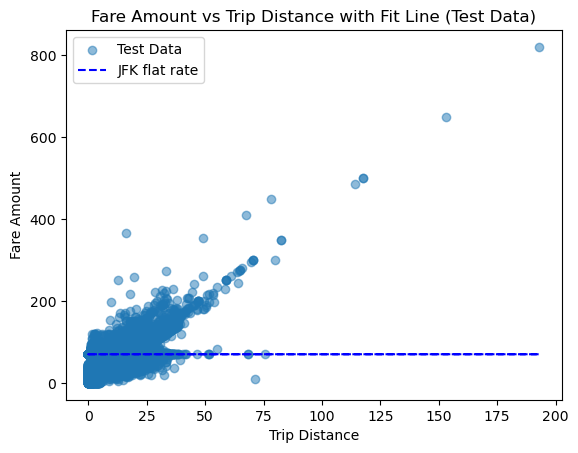

In [20]:

X_test = test[['trip_distance']]
y_test = test['fare_amount']

# Create scatter plot of test data
plt.scatter(X_test, y_test, alpha=0.5, label='Test Data')

# Plot the regression line using the trained model


# Custom line to show secondary regime
custom_slope = 0
custom_intercept = 70
plt.plot(X_test, custom_slope * X_test + custom_intercept, color='blue', linestyle='--', label='JFK flat rate')


# Add labels and title
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Fare Amount vs Trip Distance with Fit Line (Test Data)')
plt.legend()

# Display the plot
plt.show()


In [ ]:
test[(test['trip_distance']<10) & (test['fare_amount']>200)]

test[(test['trip_distance']==8)]['fare_amount'].value_counts()

fare_amount
32.4    91
33.1    90
33.8    86
31.7    81
34.5    79
        ..
64.5     1
21.5     1
60.5     1
56.5     1
50.0     1
Name: count, Length: 66, dtype: int64

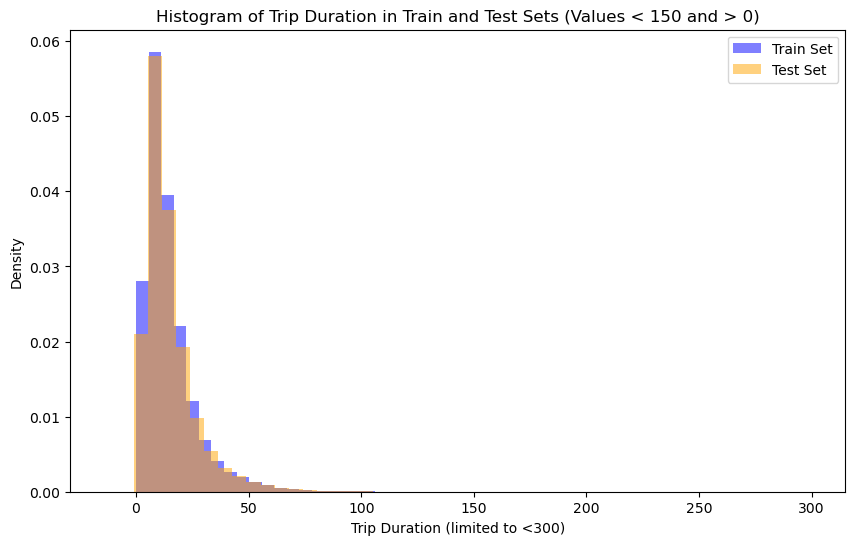

In [ ]:
# Plot the histograms
plt.figure(figsize=(10, 6))

# Train set histogram
plt.hist(train['trip_duration'], bins=50, color='blue', alpha=0.5, density=True, label='Train Set')

# Test set histogram
plt.hist(test['trip_duration'], bins=50, color='orange', alpha=0.5, density=True, label='Test Set')

# Add labels and title
plt.xlabel('Trip Duration (limited to <300)')
plt.ylabel('Density')
plt.title('Histogram of Trip Duration in Train and Test Sets (Values < 150 and > 0)')
plt.legend()
plt.show()

#### Bivariée

In [ ]:
numerical_vars = train.select_dtypes(include=['float64', 'int64']).columns

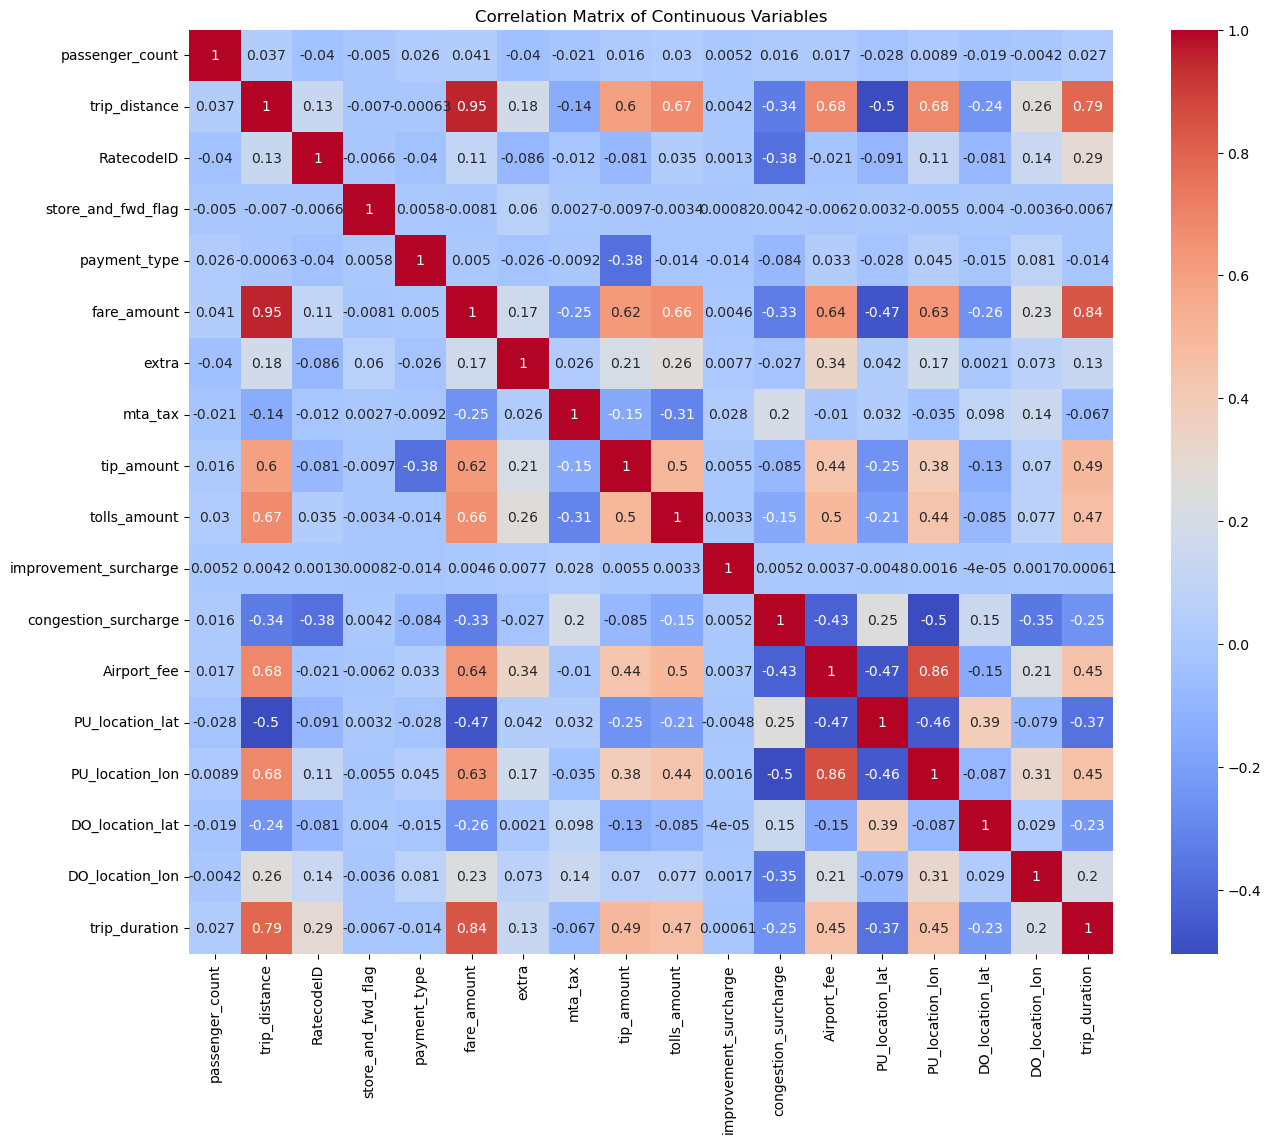

In [ ]:
# Plotting the correlation matrix
plt.figure(figsize=(15, 12))
#sns.heatmap(train[numerical_vars].corr(), annot=True, cmap='coolwarm', square=True)
sns.heatmap(train[train['trip_duration'] < 300][numerical_vars].corr(), annot=True, cmap='coolwarm', square=True)

plt.title('Correlation Matrix of Continuous Variables')
plt.show()

#### Location variables

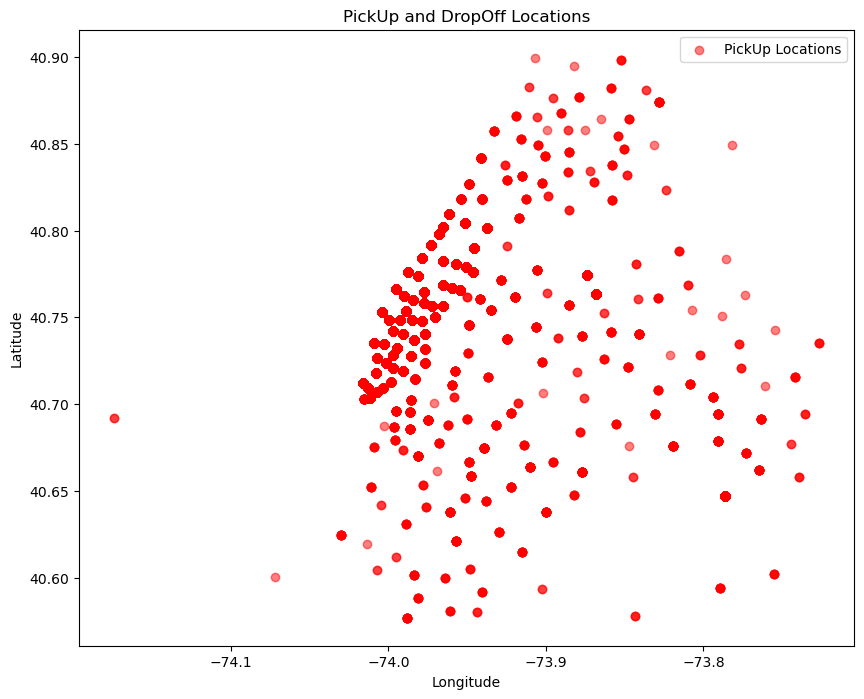

In [ ]:
import matplotlib.pyplot as plt

# Extract coordinates for pickup and dropoff locations
PU_lat = train['PU_location_lat']
PU_lon = train['PU_location_lon']
DO_lat = train['DO_location_lat']
DO_lon = train['DO_location_lon']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot pickup locations in red
plt.scatter(PU_lon, PU_lat, color='red', label='PickUp Locations', alpha=0.5)

#Plot dropoff locations in green
#plt.scatter(DO_lon, DO_lat, color='green', label='DropOff Locations', alpha=0.5)

# Draw a dashed line between each pickup and dropoff point for the same trip
'''
for i in range(len(PU_lat)):
    plt.plot([PU_lon[i], DO_lon[i]], [PU_lat[i], DO_lat[i]], 'k--', alpha=0.3)
'''
# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('PickUp and DropOff Locations')
plt.legend()
plt.show()


## Feature engineering

On se dispose dans cette section a creer de covariables supplementaires potentiellement representatives et informatives

### Categorical variable encoding

In [ ]:
# VendorID, RateCodeID et Payment_type: one-hot

categorical_features = ['VendorID', 'RateCodeID', 'Payment_type']

train = pd.get_dummies(train, columns=['VendorID', 'RatecodeID', 'payment_type'], dtype=int) # On ajoute dtype int à la fin pour assurer un format non-booléen afin de garantir la compatibilité avec scikit learn
test = pd.get_dummies(test, columns=['VendorID', 'RatecodeID', 'payment_type'], dtype=int)

train, test = train.align(test, join='left', axis=1, fill_value=0) # Certaines catégories n'apparaissent que dans le train set, il faut donc adapter l'encoding dans le test set. 
test = test.drop(columns=['tip_amount'])


### Features derivées des pickup_datetime et dropoff_datetime

In [ ]:
# trip speed
train['trip_speed'] = train['trip_distance'] / train['trip_duration']
test['trip_speed'] = test['trip_distance'] / test['trip_duration']

In [ ]:
# Cyclical encoding for the time variable
# Convert 'tpep_pickup_datetime' to datetime if it's not already
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Extract hour, minute, and second
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train['minute'] = train['tpep_pickup_datetime'].dt.minute
train['second'] = train['tpep_pickup_datetime'].dt.second

# Calculate total seconds from midnight for each datetime entry
train['seconds_from_midnight'] = train['hour'] * 3600 + train['minute'] * 60 + train['second']

# Perform cyclic encoding using sine and cosine
train['time_sin'] = np.sin(2 * np.pi * train['seconds_from_midnight'] / 86400)  # 86400 seconds in a day
train['time_cos'] = np.cos(2 * np.pi * train['seconds_from_midnight'] / 86400)

# Drop intermediate columns if not needed
train.drop(columns=['hour', 'minute', 'second', 'seconds_from_midnight'], inplace=True)


test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Extract hour, minute, and second
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test['minute'] = test['tpep_pickup_datetime'].dt.minute
test['second'] = test['tpep_pickup_datetime'].dt.second

# Calculate total seconds from midnight for each datetime entry
test['seconds_from_midnight'] = test['hour'] * 3600 + test['minute'] * 60 + test['second']

# Perform cyclic encoding using sine and cosine
test['time_sin'] = np.sin(2 * np.pi * test['seconds_from_midnight'] / 86400)  # 86400 seconds in a day
test['time_cos'] = np.cos(2 * np.pi * test['seconds_from_midnight'] / 86400)

# Drop intermediate columns if not needed
test.drop(columns=['hour', 'minute', 'second', 'seconds_from_midnight'], inplace=True)




### Features derivées de variables d'emplacement

In [ ]:
# Create a combined pickup location column
'''
train['PU_location'] = train[['PU_location_lat', 'PU_location_lon']].apply(tuple, axis=1)
# Factorize the unique pickup locations
train['PU_location_level'] = pd.factorize(train['PU_location'])[0]

# Create a combined dropoff location column
train['DO_location'] = train[['DO_location_lat', 'DO_location_lon']].apply(tuple, axis=1)
# Factorize the unique dropoff locations
train['DO_location_level'] = pd.factorize(train['DO_location'])[0]

# Drop the temporary combined columns if not needed
train = train.drop(['PU_location', 'DO_location'], axis=1)
'''


"\ntrain['PU_location'] = train[['PU_location_lat', 'PU_location_lon']].apply(tuple, axis=1)\n# Factorize the unique pickup locations\ntrain['PU_location_level'] = pd.factorize(train['PU_location'])[0]\n\n# Create a combined dropoff location column\ntrain['DO_location'] = train[['DO_location_lat', 'DO_location_lon']].apply(tuple, axis=1)\n# Factorize the unique dropoff locations\ntrain['DO_location_level'] = pd.factorize(train['DO_location'])[0]\n\n# Drop the temporary combined columns if not needed\ntrain = train.drop(['PU_location', 'DO_location'], axis=1)\n"

### Feature importance

## Model fitting

In [ ]:
## Model fitting
#train = train.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon'])
#test = test.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon'])

train = train.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime',])
test = test.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime',])

X_train = train.drop(columns=['tip_amount'])
y_train = train['tip_amount']

X_test = test

In [ ]:
#Linear regression
'''
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
'''

'\nfrom sklearn.linear_model import LinearRegression\n\nmodel = LinearRegression()\n\nmodel.fit(X_train, y_train)\ny_pred = model.predict(X_test)\n'

In [ ]:
#GAM
'''
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit a GLM with Gaussian family (similar to linear regression)
glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Predict on the test set
y_pred = glm_results.predict(X_test)
'''

'\nimport statsmodels.api as sm\nX_train = sm.add_constant(X_train)\nX_test = sm.add_constant(X_test)\n\n# Fit a GLM with Gaussian family (similar to linear regression)\nglm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())\nglm_results = glm_model.fit()\n\n# Predict on the test set\ny_pred = glm_results.predict(X_test)\n'

##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
sdfsdf

NameError: name 'sdfsdf' is not defined

##### Boosting

In [ ]:
#Boosting
# Initialize the model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=True)

[0]	validation_0-rmse:2.95185
[1]	validation_0-rmse:2.51302
[2]	validation_0-rmse:2.26133
[3]	validation_0-rmse:2.12141
[4]	validation_0-rmse:2.04725
[5]	validation_0-rmse:2.00699
[6]	validation_0-rmse:1.98257
[7]	validation_0-rmse:1.96826
[8]	validation_0-rmse:1.96030
[9]	validation_0-rmse:1.95315
[10]	validation_0-rmse:1.94761
[11]	validation_0-rmse:1.94039
[12]	validation_0-rmse:1.93619
[13]	validation_0-rmse:1.93161
[14]	validation_0-rmse:1.92620
[15]	validation_0-rmse:1.92003
[16]	validation_0-rmse:1.91520
[17]	validation_0-rmse:1.91393
[18]	validation_0-rmse:1.91051
[19]	validation_0-rmse:1.90449
[20]	validation_0-rmse:1.89869
[21]	validation_0-rmse:1.89508
[22]	validation_0-rmse:1.89111
[23]	validation_0-rmse:1.88996
[24]	validation_0-rmse:1.88404
[25]	validation_0-rmse:1.88053
[26]	validation_0-rmse:1.87154
[27]	validation_0-rmse:1.86954
[28]	validation_0-rmse:1.86701
[29]	validation_0-rmse:1.86545
[30]	validation_0-rmse:1.85811
[31]	validation_0-rmse:1.85362
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

scorer = make_scorer(r2_score)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validated R² score: ", random_search.best_score_)

best_params = random_search.best_params_

final_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best cross-validated R² score:  0.707733128481713


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Expand the parameter grid for a more exhaustive search
param_grid = {
    'n_estimators': np.arange(50, 301, 25),  # [50, 75, 100, ..., 300]
    'learning_rate': np.linspace(0.01, 0.1, 10),  # [0.01, 0.02, ..., 0.1]
    'max_depth': np.arange(3, 11, 1),  # [3, 4, ..., 10]
    'subsample': np.linspace(0.6, 0.9, 7),  # [0.6, 0.65, ..., 0.9]
    'colsample_bytree': np.linspace(0.6, 0.9, 7),  # [0.6, 0.65, ..., 0.9]
    'gamma': np.linspace(0, 0.5, 6),  # [0.0, 0.1, ..., 0.5]
    'reg_alpha': np.linspace(0, 0.2, 5),  # [0.0, 0.05, ..., 0.2]
    'reg_lambda': np.linspace(1, 3, 5)  # [1.0, 1.5, ..., 3.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

scorer = make_scorer(r2_score)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=700,  # Increased number of parameter settings to sample
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)
print("Best cross-validated R² score:", random_search.best_score_)

best_params = random_search.best_params_

final_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)


Fitting 5 folds for each of 700 candidates, totalling 3500 fits
Best parameters found: {'subsample': 0.65, 'reg_lambda': 2.0, 'reg_alpha': 0.0, 'n_estimators': 225, 'max_depth': 6, 'learning_rate': 0.020000000000000004, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.75}
Best cross-validated R² score: 0.7082762462357624


##### Submission

In [ ]:
# Get today's date in the format YYYYMMDD
today_date = datetime.now().strftime("%Y_%m_%d")

# Create the submission DataFrame
submission = pd.DataFrame({
    'row_ID': test.index,  # Use 'row_ID' column or index from the test set
    'tip_amount': y_pred
})

# Save the submission in Parquet format with today's date in the filename
filename = f'kaggle_submission_{today_date}.parquet'
submission.to_parquet(filename, index=False)

print(f"Predictions saved to '{filename}'")


Predictions saved to 'kaggle_submission_2024_11_10.parquet'
